## Este notebook es encargado de implementar un modelo para realizar la predicción del estado emocional de una sesión de prueba

In [59]:
import pickle
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [60]:
model = pickle.load(open('./models/model', 'rb'))
# result_val = model.score(xval, yval)
# result_test = model.score(xtest, ytest)

In [61]:
df_1 = pd.read_csv("..//resources//csv//data//sujeto1-rocio-2020-10-25-biometrics.csv")
df_2 = pd.read_csv("..//resources//csv//data//sujeto2-juan-2020-11-01-biometrics.csv")
df_3 = pd.read_csv("..//resources//csv//data//sujeto3-brenda-2020-11-16-biometrics.csv")
df_4 = pd.read_csv("..//resources//csv//data//sujeto4-matias-2020-11-16-biometrics.csv")
df_5 = pd.read_csv("..//resources//csv//data//sujeto5-sebastian-2021-01-05-biometrics.csv")
df_6 = pd.read_csv("..//resources//csv//data//sujeto6-rocio-2021-01-07-biometrics.csv")

df_to_predict = df_4

df_to_predict.head()

,TimeStamp,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,ArousalMean,ValenceMean,ArousalSD,ValenceSD,PhaseName,MatchesSam
0,2020-11-16 16:48:31,70.3,854,0.1,5.31,0,1,0.0,0.0,0.0,0.0,NaN,False
1,2020-11-16 16:48:32,71.3,841,0.0,5.30,0,1,0.0,0.0,0.0,0.0,NaN,False
2,2020-11-16 16:48:33,72.8,824,0.0,5.26,0,1,0.0,0.0,0.0,0.0,NaN,False
3,2020-11-16 16:48:33,74.3,807,0.0,5.23,0,1,0.0,0.0,0.0,0.0,NaN,False
4,2020-11-16 16:48:35,77.3,776,0.0,5.16,0,1,0.0,0.0,0.0,0.0,NaN,False


In [62]:
def add_prev_values(df, col):
    df.loc[0, f'{col}-4'] = df.loc[0, col]
    df.loc[0, f'{col}-3'] = df.loc[0, col]
    df.loc[0, f'{col}-2'] = df.loc[0, col]
    df.loc[0, f'{col}-1'] = df.loc[0, col]

    for i in range(0, len(df)):
        if i >= 4:
            df.loc[i, f'{col}-4'] = df.loc[i-4, col]
            df.loc[i, f'{col}-3'] = df.loc[i-3, col]
            df.loc[i, f'{col}-2'] = df.loc[i-2, col]
            df.loc[i, f'{col}-1'] = df.loc[i-1, col]
        else:
            df.loc[i, f'{col}-4'] = df.loc[i, col]
            df.loc[i, f'{col}-3'] = df.loc[i, col]
            df.loc[i, f'{col}-2'] = df.loc[i, col]
            df.loc[i, f'{col}-1'] = df.loc[i, col]

In [63]:
# Función que determina cuando un sujeto se encuentra en un estado de excitación (1) o relajación (0) dado un valor de arousal.
def isAroused(arousal):
    return 0 if arousal < 5 else 1

In [64]:
df_to_standarize = df_to_predict.copy()
    
# Se remueven las mediciones sin estímulo (previas al inicio de estímulos), para no ofuscar el entrenamiento
filterNoArousalMeasurements = df_to_standarize['ArousalMean'] > 0
df_to_standarize = df_to_standarize[filterNoArousalMeasurements]

# remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
# filterNoMatchesSAMMeasurements = filtered1['MatchesSam'] == True
# df_to_standarize = df_to_standarize[filterNoMatchesSAMMeasurements]

# Se agrega la columna Aroused (0/1) para la clasificación binaria
df_to_standarize['Aroused'] = df_to_standarize['ArousalMean'].map(isAroused)

columns_to_standarize = ['HR', 'RR', 'HRV', 'MicroSiemens']

scaler = preprocessing.StandardScaler()
standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

standarized_df_with_rest_of_data = np.append(standarized_df, df_to_standarize[['SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp']], axis=1)

# Se convierte a DataFrame
standarized_df_with_rest_of_data = pd.DataFrame(standarized_df_with_rest_of_data, columns=['HR', 'RR', 'HRV', 'MicroSiemens', 'SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp'])

# Conversión de tipos
standarized_df_with_rest_of_data['HR'] = standarized_df_with_rest_of_data['HR'].astype(float)
standarized_df_with_rest_of_data['RR'] = standarized_df_with_rest_of_data['RR'].astype(float)
standarized_df_with_rest_of_data['HRV'] = standarized_df_with_rest_of_data['HRV'].astype(float)
standarized_df_with_rest_of_data['MicroSiemens'] = standarized_df_with_rest_of_data['MicroSiemens'].astype(float)
standarized_df_with_rest_of_data['SCR'] = standarized_df_with_rest_of_data['SCR'].astype(int)
standarized_df_with_rest_of_data['SCR_MIN'] = standarized_df_with_rest_of_data['SCR_MIN'].astype(int)
standarized_df_with_rest_of_data['PhaseName'] = standarized_df_with_rest_of_data['PhaseName']
standarized_df_with_rest_of_data['ArousalMean'] = standarized_df_with_rest_of_data['ArousalMean'].astype(float)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['TimeStamp'] = standarized_df_with_rest_of_data['TimeStamp']

standarized_df_with_rest_of_data

add_prev_values(standarized_df_with_rest_of_data, "HR")
add_prev_values(standarized_df_with_rest_of_data, "HRV")
add_prev_values(standarized_df_with_rest_of_data, "MicroSiemens")

df_to_predict = standarized_df_with_rest_of_data
df_to_predict

,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,PhaseName,ArousalMean,Aroused,TimeStamp,...,HR-2,HR-1,HRV-4,HRV-3,HRV-2,HRV-1,MicroSiemens-4,MicroSiemens-3,MicroSiemens-2,MicroSiemens-1
0,3.411259,-3.046116,-0.729571,-0.788037,0,6,HA_PV,6.440000,1,2020-11-16 16:49:40,...,3.411259,3.411259,-0.729571,-0.729571,-0.729571,-0.729571,-0.788037,-0.788037,-0.788037,-0.788037
1,3.041081,-2.771008,-0.230610,-0.812732,0,6,HA_PV,6.440000,1,2020-11-16 16:49:41,...,3.041081,3.041081,-0.230610,-0.230610,-0.230610,-0.230610,-0.812732,-0.812732,-0.812732,-0.812732
2,2.448796,-2.305442,0.841104,-0.862122,0,6,HA_PV,6.440000,1,2020-11-16 16:49:41,...,2.448796,2.448796,0.841104,0.841104,0.841104,0.841104,-0.862122,-0.862122,-0.862122,-0.862122
3,1.017439,-1.056877,1.248706,-0.960902,0,6,HA_PV,6.990000,1,2020-11-16 16:49:42,...,1.017439,1.017439,1.248706,1.248706,1.248706,1.248706,-0.960902,-0.960902,-0.960902,-0.960902
4,0.647261,-0.718284,1.434938,-0.960902,0,6,HA_PV,6.990000,1,2020-11-16 16:49:43,...,2.448796,1.017439,-0.729571,-0.230610,0.841104,1.248706,-0.788037,-0.812732,-0.862122,-0.960902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.054976,-0.125745,-0.666323,-0.590476,1,3,LA_NV,3.403846,0,2020-11-16 16:53:18,...,-0.068417,-0.537309,0.180507,-0.104112,-0.371162,-0.578477,-0.145965,-0.096575,-0.318831,-0.541086
220,0.622583,-0.697122,-0.638212,-0.689256,1,3,LA_NV,3.423077,0,2020-11-16 16:53:19,...,-0.537309,0.054976,-0.104112,-0.371162,-0.578477,-0.666323,-0.096575,-0.318831,-0.541086,-0.590476
221,0.005619,-0.062258,-0.624157,-0.788037,1,4,LA_NV,3.423077,0,2020-11-16 16:53:20,...,0.054976,0.622583,-0.371162,-0.578477,-0.666323,-0.638212,-0.318831,-0.541086,-0.590476,-0.689256
222,-0.216488,0.170525,-0.652267,-0.936207,1,4,LA_NV,3.423077,0,2020-11-16 16:53:21,...,0.622583,0.005619,-0.578477,-0.666323,-0.638212,-0.624157,-0.541086,-0.590476,-0.689256,-0.788037


In [65]:
y_pred = model.predict(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']].values)

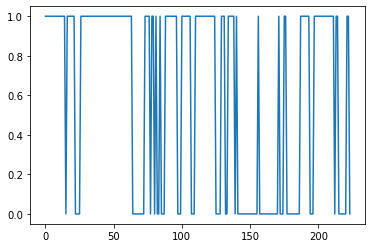

In [66]:
plt.plot(y_pred)
plt.show()

In [67]:
model.score(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']], df_to_predict[['Aroused']])

0.7008928571428571

In [68]:
df_to_predict['ArousalPred'] = y_pred

df_to_predict.to_csv(r'./3_prediction.csv', date_format='%s', index = False)